# Import Libraries

In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data Transformations

In [12]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [13]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [14]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


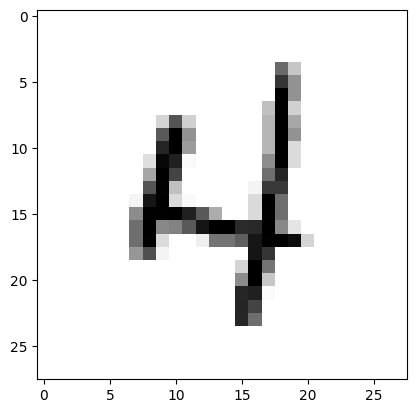

In [15]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# MORE

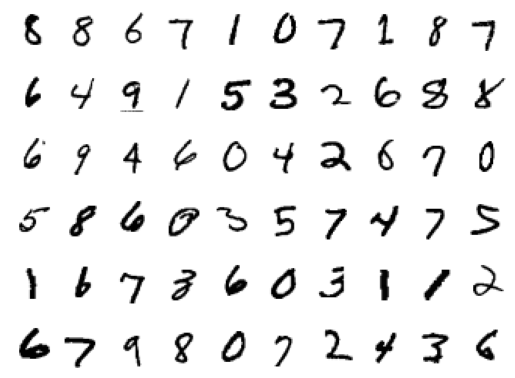

In [16]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The Model

In [17]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 28>28 | 3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 28 > 28 |  5
        self.pool1 = nn.MaxPool2d(2, 2) # 28 > 14 | 10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 14> 14 | 12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #14 > 14 | 14
        self.pool2 = nn.MaxPool2d(2, 2) # 14 > 7 | 28
        self.conv5 = nn.Conv2d(256, 512, 3) # 7 > 5 | 30
        self.conv6 = nn.Conv2d(512, 1024, 3) # 5 > 3 | 32 | 3*3*1024 | 3x3x1024x10 |
        self.conv7 = nn.Conv2d(1024, 10, 3) # 3 > 1 | 34 | > 1x1x10

    def forward(self, x):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        # x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10) #1x1x10> 10
        return F.log_softmax(x, dim=-1)

# Model Params

In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (

# Training and Testing

In [19]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model,device,train_loader,optimizer,epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # Init
    optimizer.zero_grad()
    # Predict
    y_pred = model(data)
    # Calculate loss
    loss = F.nll_loss(y_pred,target)
    train_losses.append(loss)
    # Backpropagation
    loss.backward()
    optimizer.step()
    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model,device,test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [20]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0507080964744091 Batch_id=468 Accuracy=88.06: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]



Test set: Average loss: 0.0620, Accuracy: 9792/10000 (97.92%)

EPOCH: 1


Loss=0.023145385086536407 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]



Test set: Average loss: 0.0354, Accuracy: 9881/10000 (98.81%)

EPOCH: 2


Loss=0.04885797202587128 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:21<00:00, 22.05it/s]



Test set: Average loss: 0.0349, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.0063417707569897175 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]



Test set: Average loss: 0.0291, Accuracy: 9902/10000 (99.02%)

EPOCH: 4


Loss=0.012422304600477219 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 22.57it/s]



Test set: Average loss: 0.0274, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.006237977650016546 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]



Test set: Average loss: 0.0275, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.045120906084775925 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]



Test set: Average loss: 0.0275, Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.0030778285581618547 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]



Test set: Average loss: 0.0257, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.0016218111850321293 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:20<00:00, 22.89it/s]



Test set: Average loss: 0.0317, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.001106282346881926 Batch_id=468 Accuracy=99.79: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]



Test set: Average loss: 0.0260, Accuracy: 9924/10000 (99.24%)

EPOCH: 10


Loss=0.003901012474671006 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]



Test set: Average loss: 0.0278, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.00047942480887286365 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.0313, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.0004212866479065269 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]



Test set: Average loss: 0.0313, Accuracy: 9914/10000 (99.14%)

EPOCH: 13


Loss=0.02912498079240322 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:21<00:00, 21.56it/s]



Test set: Average loss: 0.0432, Accuracy: 9902/10000 (99.02%)

EPOCH: 14


Loss=1.2781672012351919e-05 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]



Test set: Average loss: 0.0302, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=8.000892557902262e-05 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]



Test set: Average loss: 0.0283, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=1.830836663430091e-05 Batch_id=468 Accuracy=99.98: 100%|██████████| 469/469 [00:20<00:00, 23.00it/s]



Test set: Average loss: 0.0362, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.00028296615346334875 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]



Test set: Average loss: 0.0296, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.00013901121565140784 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]



Test set: Average loss: 0.0314, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=2.1443283912958577e-06 Batch_id=468 Accuracy=100.00: 100%|██████████| 469/469 [00:21<00:00, 21.77it/s]



Test set: Average loss: 0.0317, Accuracy: 9928/10000 (99.28%)



In [22]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

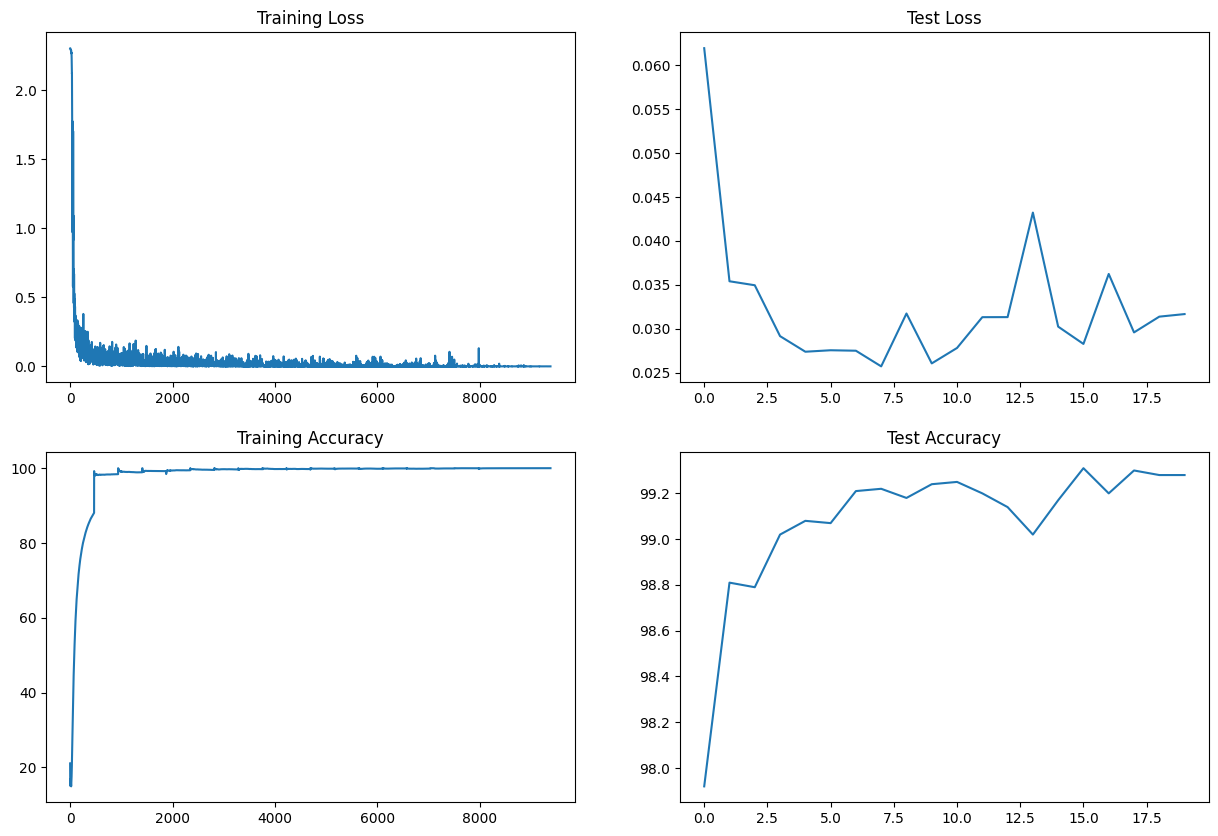

In [23]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target
  1.Get the set-up right

  2.Set Transforms

  3.Set Data Loader

  4.Set Basic Working Code

  5.Set Basic Training  & Test Loop

## Result
  1. Our Best Training Accuracy is 100 %

  2. Our Best Testing Accuracy is 99.31 %

## Analysis
  1. Model is extremely heavy for such a simple problem of MNIST

  2. Model is overfitting, as the difference between training and testing accuracy is high. Training accuracy touches 100 % but testing accuracy was less